In [1]:
# General Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Building Model
from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy

# Training Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

# Data Processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img


In [2]:
# Global variables
SAVE = False
SEED = 111

# Setting seed for consistent results
tf.keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Data Visualization updates
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams.update({'font.size': 14})

# Data Classifications
CLASS_TYPES = ['pituitary', 'notumor', 'meningioma', 'glioma']
N_TYPES = len(CLASS_TYPES)

In [3]:
def get_data_labels(directory):
    paths = []
    labels = []
    for label in os.listdir(directory):  # Iterate over each subfolder
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):  # Ensure it's a directory
            for file in os.listdir(label_path):  # Iterate over files in subfolder
                file_path = os.path.join(label_path, file)
                paths.append(file_path)
                labels.append(label)
    return paths, labels
# Setting up file paths for training and testing
train_dir ='dataset/training'
test_dir = 'dataset/testing'

# Getting data using above function
train_paths, train_labels = get_data_labels(train_dir)
test_paths, test_labels = get_data_labels(test_dir)

# Printing traing and testing sample sizes
print('Training')
print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_labels)}')
print('\nTesting')
print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_labels)}')

Training
Number of Paths: 5712
Number of Labels: 5712

Testing
Number of Paths: 1311
Number of Labels: 1311


A balanced distribution of categories in our training data is crucial for optimal model learning. It allows for comprehensive understanding of each category's characteristics, prevents biases, enhances generalization, and enables iterative refinement, leading to improved performance in accurately categorizing new data.

We also have a nice split percentage in our training and testing set.

x reshaped: (1, 150, 150, 3)


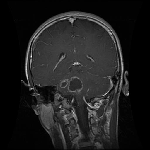

In [4]:
# getting image to test output
im = load_img(train_paths[3], target_size=(150, 150))
im = img_to_array(im)

# Reshape it to (1, 150, 150, 3)
im = np.expand_dims(im, axis=0)
print(f'x reshaped: {im.shape}')

# normilzation tensor
im /= np.max(im) # ~ np.max(img_tensor)

# Convert the array back to the image format
im = array_to_img(im[0])
display(im)

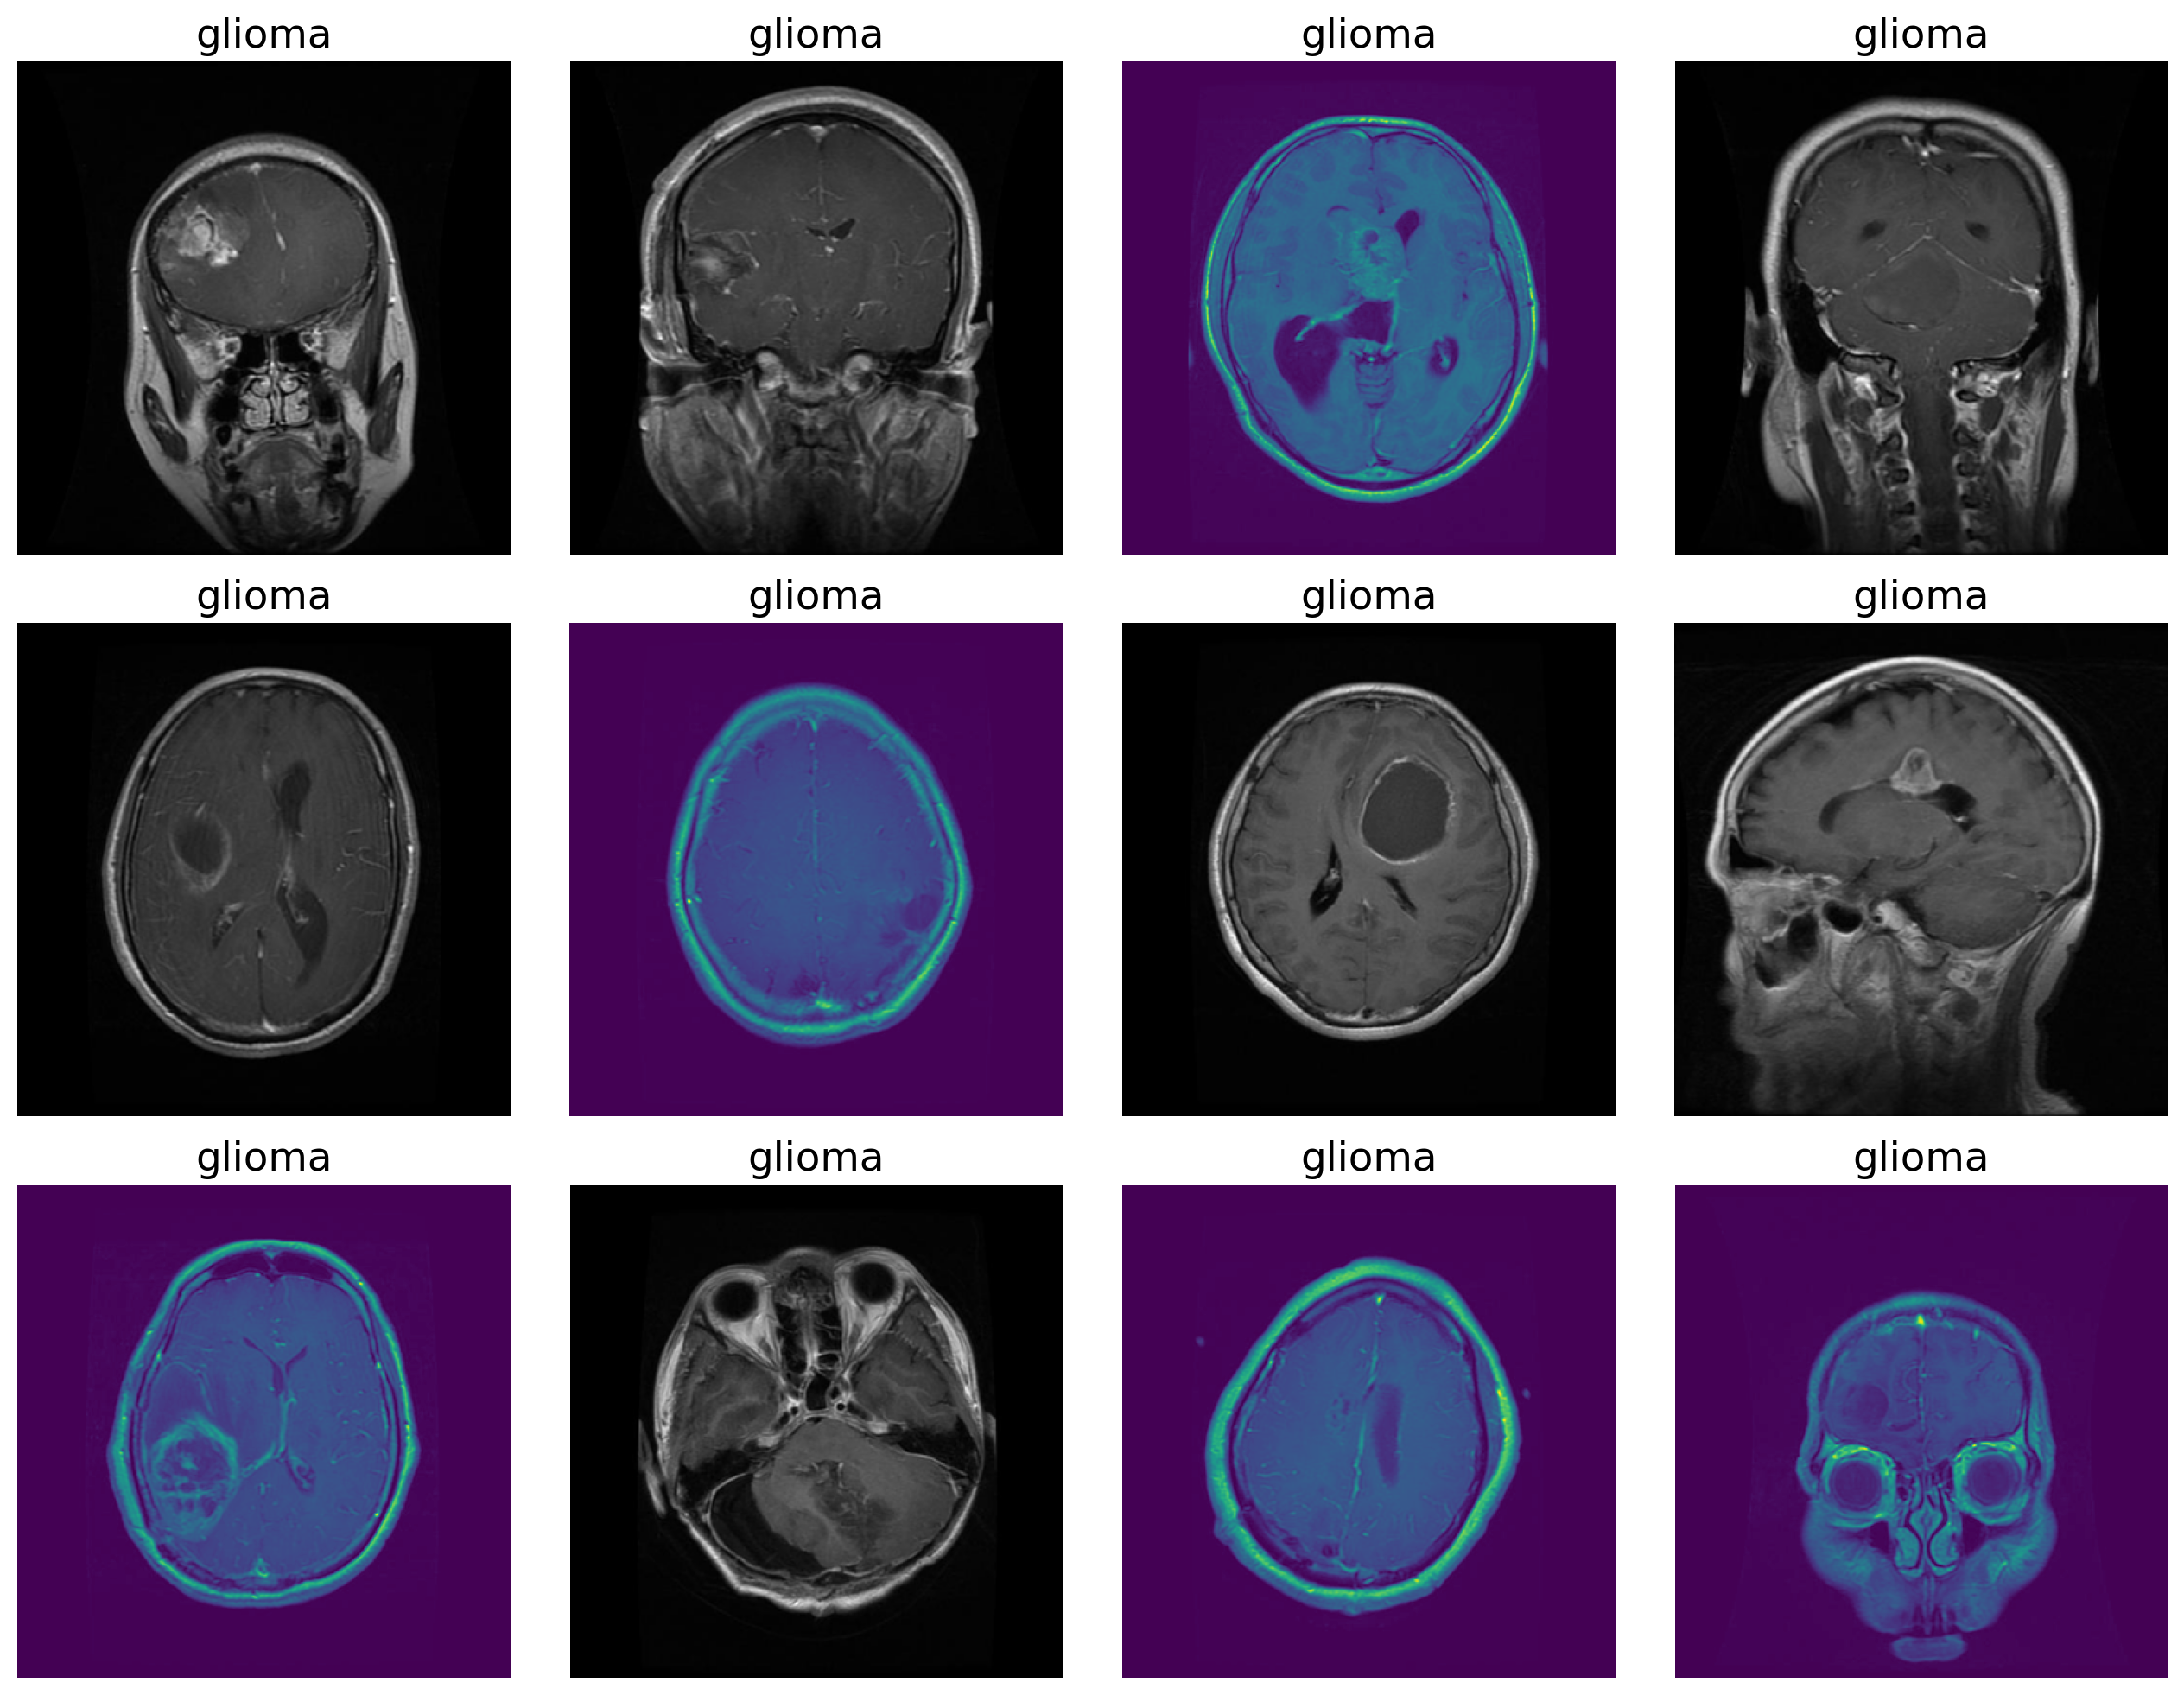

In [5]:
from PIL import Image
def show_images(paths, labels, im_size=350, figsize=(13, 10), index_list=None):
    if index_list is None:
        index_list = range(len(paths))  # Default to showing all images
    num_images = len(index_list)
    cols = 4  # Number of images per row
    rows = (num_images // cols) + (num_images % cols > 0)
    
    plt.figure(figsize=figsize)
    for i, idx in enumerate(index_list):
        try:
            # Load image
            img = Image.open(paths[idx])
            img = img.resize((im_size, im_size))  # Resize image
            
            # Display image
            plt.subplot(rows, cols, i + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(labels[idx])
        except Exception as e:
            print(f"Error loading image at index {idx}: {e}")
    
    plt.tight_layout()
    plt.show()
# Four different data classification images, from three different angles (images are independent)
show_images(train_paths, train_labels, im_size=350, figsize=(13,10),
            index_list=[0, 94, 235, 17,
                        61, 324, 55, 45,
                        374, 65, 391, 488])

In [6]:
# Image size
image_size = (150, 150)

# Training batch size
batch_size = 32

In [7]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   brightness_range=(0.85, 1.15),
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,
                                   zoom_range=0,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")


# applying the generator to training data with constant seed
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    seed=SEED)

# No augmentation of the test data, just rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# applying the generator to testing data with constant seed
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=False,
                                                  seed=SEED)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [8]:
# Accessing class indices for training data generator
class_indices_train = train_generator.class_indices
class_indices_train_list = list(train_generator.class_indices.keys())


# Displaying categorical types
print("Categorical types for the training data:")
print(class_indices_train)

Categorical types for the training data:
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


Found 5712 images belonging to 4 classes.


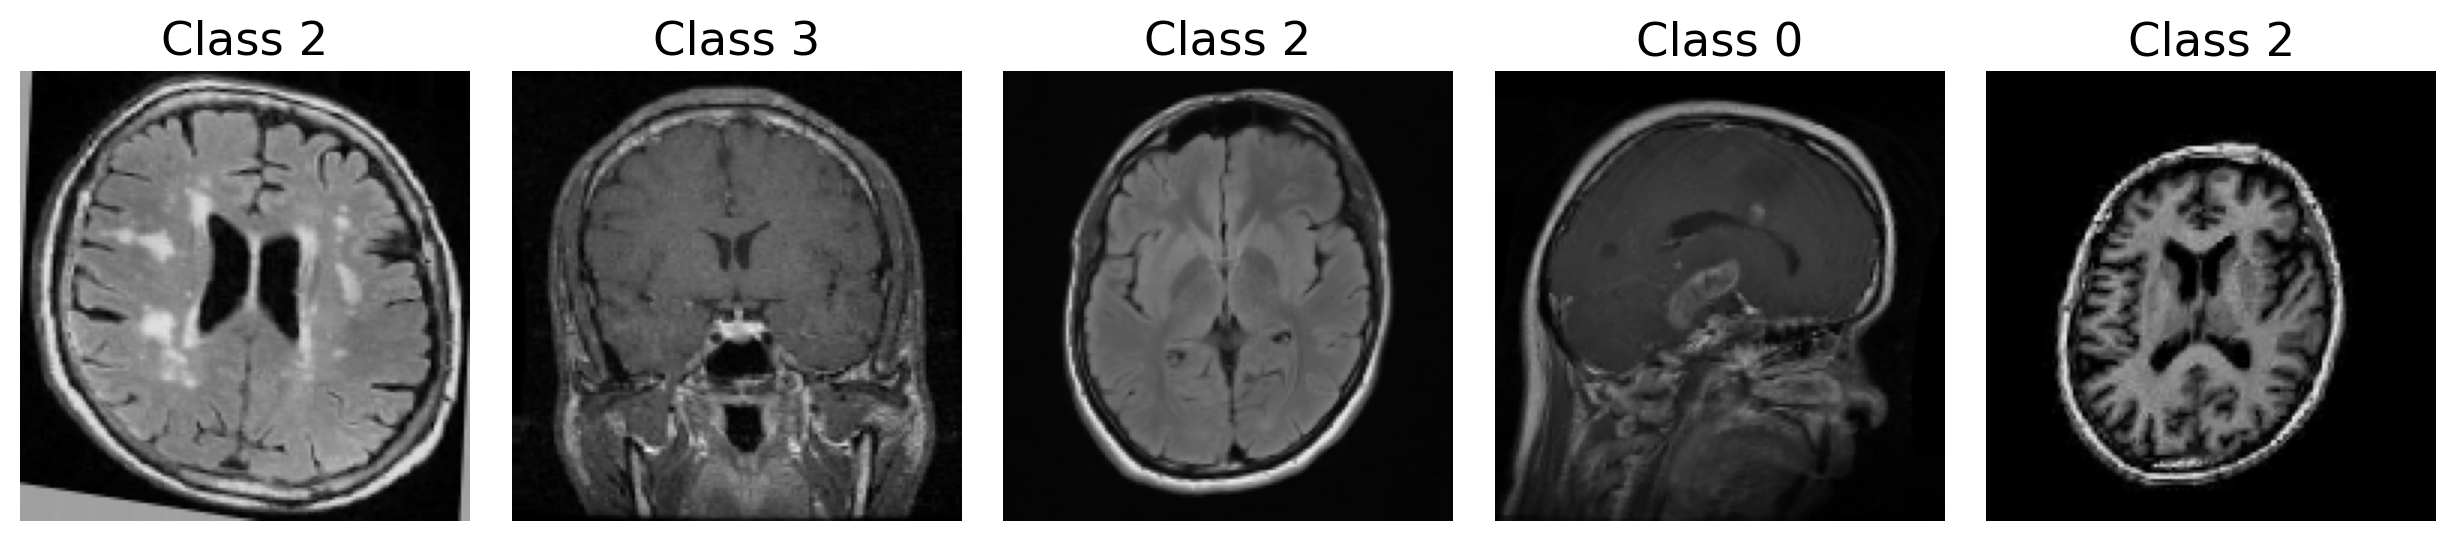

In [9]:
def show_ImageDataGenerator(datagen, directory, num_samples=5, figsize=(12.5, 8), save=False):
    # Create a generator with a fixed batch size
    data_iter = datagen.flow_from_directory(directory, batch_size=num_samples, 
                                            target_size=(150, 150), shuffle=True, seed=SEED)
    images, labels = next(data_iter)  # Get a batch of images and labels

    plt.figure(figsize=figsize)
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i])  # Rescale data is in range [0, 1]
        plt.axis('off')
        plt.title(f"Class {np.argmax(labels[i])}")
    
    plt.tight_layout()
    if save:
        plt.savefig("datagen_samples.png")
    plt.show()

# Display augmented images
show_ImageDataGenerator(train_datagen, train_dir, num_samples=5, figsize=(12.5, 8), save=SAVE)


In [10]:
# Image shape: height, width, RBG
image_shape = (image_size[0], image_size[1], 3)

# Training epochs
epochs = 40

# Steps per epoch
steps_per_epoch = train_generator.samples // batch_size

# Validation steps
validation_steps = test_generator.samples // batch_size

print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')
print(f'Steps Per Epoch: {steps_per_epoch}')
print(f'Validation steps: {validation_steps}')

Image shape: (150, 150, 3)
Epochs: 40
Batch size: 32
Steps Per Epoch: 178
Validation steps: 40


In [11]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models

# Define the model architecture
model = models.Sequential([
    # Convolutional layer 1
    Conv2D(32, (4, 4), activation="relu", input_shape=image_shape),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 2
    Conv2D(64, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 3
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 4
    Conv2D(128, (4, 4), activation="relu"),
    Flatten(),

    # Full connect layers
    Dense(512, activation="relu"),
    Dropout(0.5, seed=SEED),
    Dense(N_TYPES, activation="softmax")
])

# Summarize the model
model.summary()

# Compile the model
optimizer = Adam(learning_rate=0.001, beta_1=0.869, beta_2=0.995)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])




C:\Users\msi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 147, 147, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 46, 46, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 1, 1, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 495,972 (1.89 MB)

 Trainable params: 495,972 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

C:\Users\msi\anaconda3\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


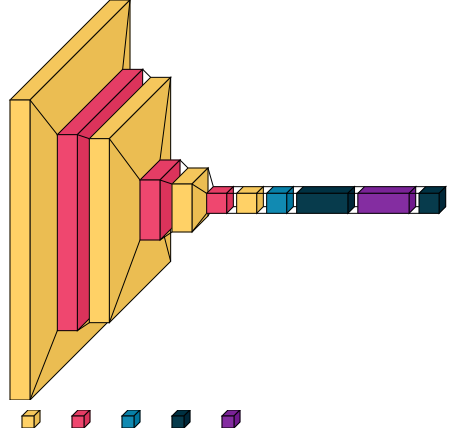

In [12]:
 from visualkeras import layered_view

# Visualize the model
layered_view(model, legend=True, max_xy=300)

In [13]:
# Define the model checkpoint callback
checkpoint = ModelCheckpoint(
    'best_model.keras',               # Change the extension to .keras
    monitor='val_loss',               # Metric to monitor
    save_best_only=True,              # Save only the best model
    mode='min',                       # Save the model when the validation loss decreases
    verbose=1                         # Display a message when the model is saved
)

# Stop training if loss doesn't keep decreasing.
model_es = EarlyStopping(monitor='loss', min_delta=1e-9, patience=8, verbose=True)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=True)

# Training the model
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=test_generator,
                    validation_steps=validation_steps,
                    callbacks=[model_es, model_rlr, checkpoint])  # Don't forget to add checkpoint here


C:\Users\msi\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.4813 - loss: 1.0827
Epoch 1: val_loss improved from inf to 0.73287, saving model to best_model.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 82s 440ms/step - accuracy: 0.4822 - loss: 1.0812 - val_accuracy: 0.6969 - val_loss: 0.7329 - learning_rate: 0.0010
Epoch 2/40
  1/178 ━━━━━━━━━━━━━━━━━━━━ 1:03 361ms/step - accuracy: 0.7812 - loss: 0.5121
Epoch 2: val_loss improved from 0.73287 to 0.47106, saving model to best_model.keras


C:\Users\msi\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7812 - loss: 0.5121 - val_accuracy: 0.8710 - val_loss: 0.4711 - learning_rate: 0.0010
Epoch 3/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.8028 - loss: 0.4887
Epoch 3: val_loss did not improve from 0.47106
178/178 ━━━━━━━━━━━━━━━━━━━━ 69s 386ms/step - accuracy: 0.8028 - loss: 0.4887 - val_accuracy: 0.7445 - val_loss: 0.7220 - learning_rate: 0.0010
Epoch 4/40
  1/178 ━━━━━━━━━━━━━━━━━━━━ 27s 156ms/step - accuracy: 0.6250 - loss: 0.6488
Epoch 4: val_loss did not improve from 0.47106
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - accuracy: 0.6250 - loss: 0.6488 - val_accuracy: 0.7419 - val_loss: 0.8685 - learning_rate: 0.0010
Epoch 5/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.8243 - loss: 0.4536
Epoch 5: val_loss did not improve from 0.47106
178/178 ━━━━━━━━━━━━━━━━━━━━ 65s 365ms/step - accuracy: 0.8244 - loss: 0.4535 - val_accuracy: 0.7688 - val_loss: 0.6348 - learning_rate: 0.0010
Epoch 6/40
  1/178 ━━━

In [14]:
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples//batch_size)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.9761 - loss: 0.0943
Test Loss: 0.07369
Test Accuracy: 0.98359


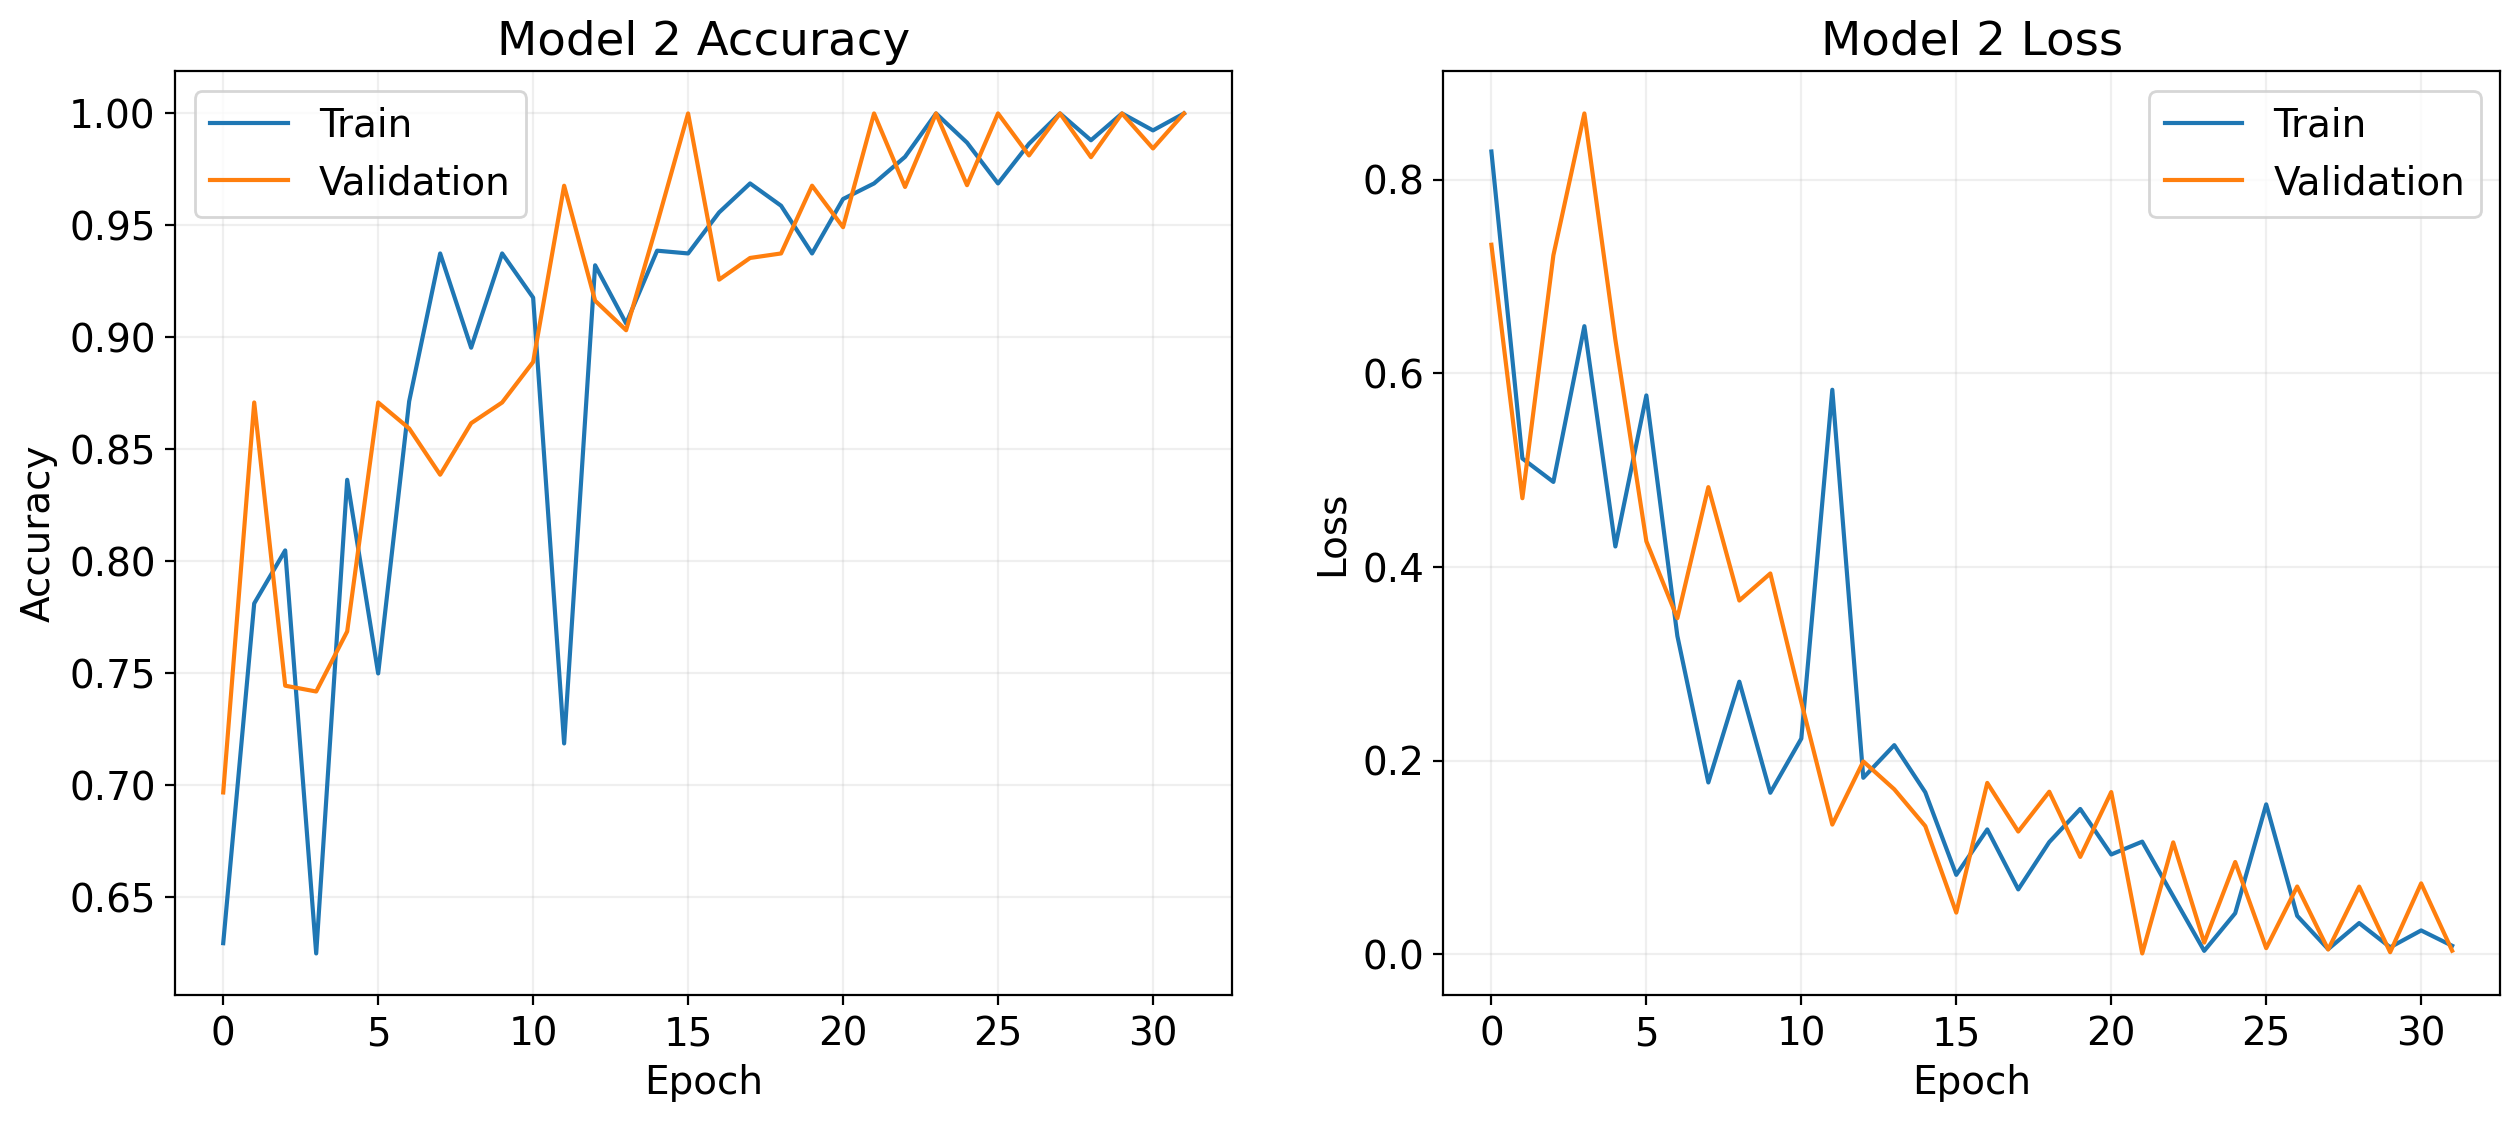

In [15]:
_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Plot the training and validation accuracy over epochs
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model 2 Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha=0.2)

# Plot the training and validation loss over epochs
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model 2 Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])
ax[1].grid(alpha=0.2)

plt.show()

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step
True labels (first 10): [0 0 0 0 0 0 0 0 0 0]
Predicted labels (first 10): [0 0 0 0 0 0 0 0 0 0]
Confusion Matrix Shape: (4, 4)
Confusion Matrix:
[[290   9   1   0]
 [  1 296   7   2]
 [  0   0 405   0]
 [  0   1   0 299]]


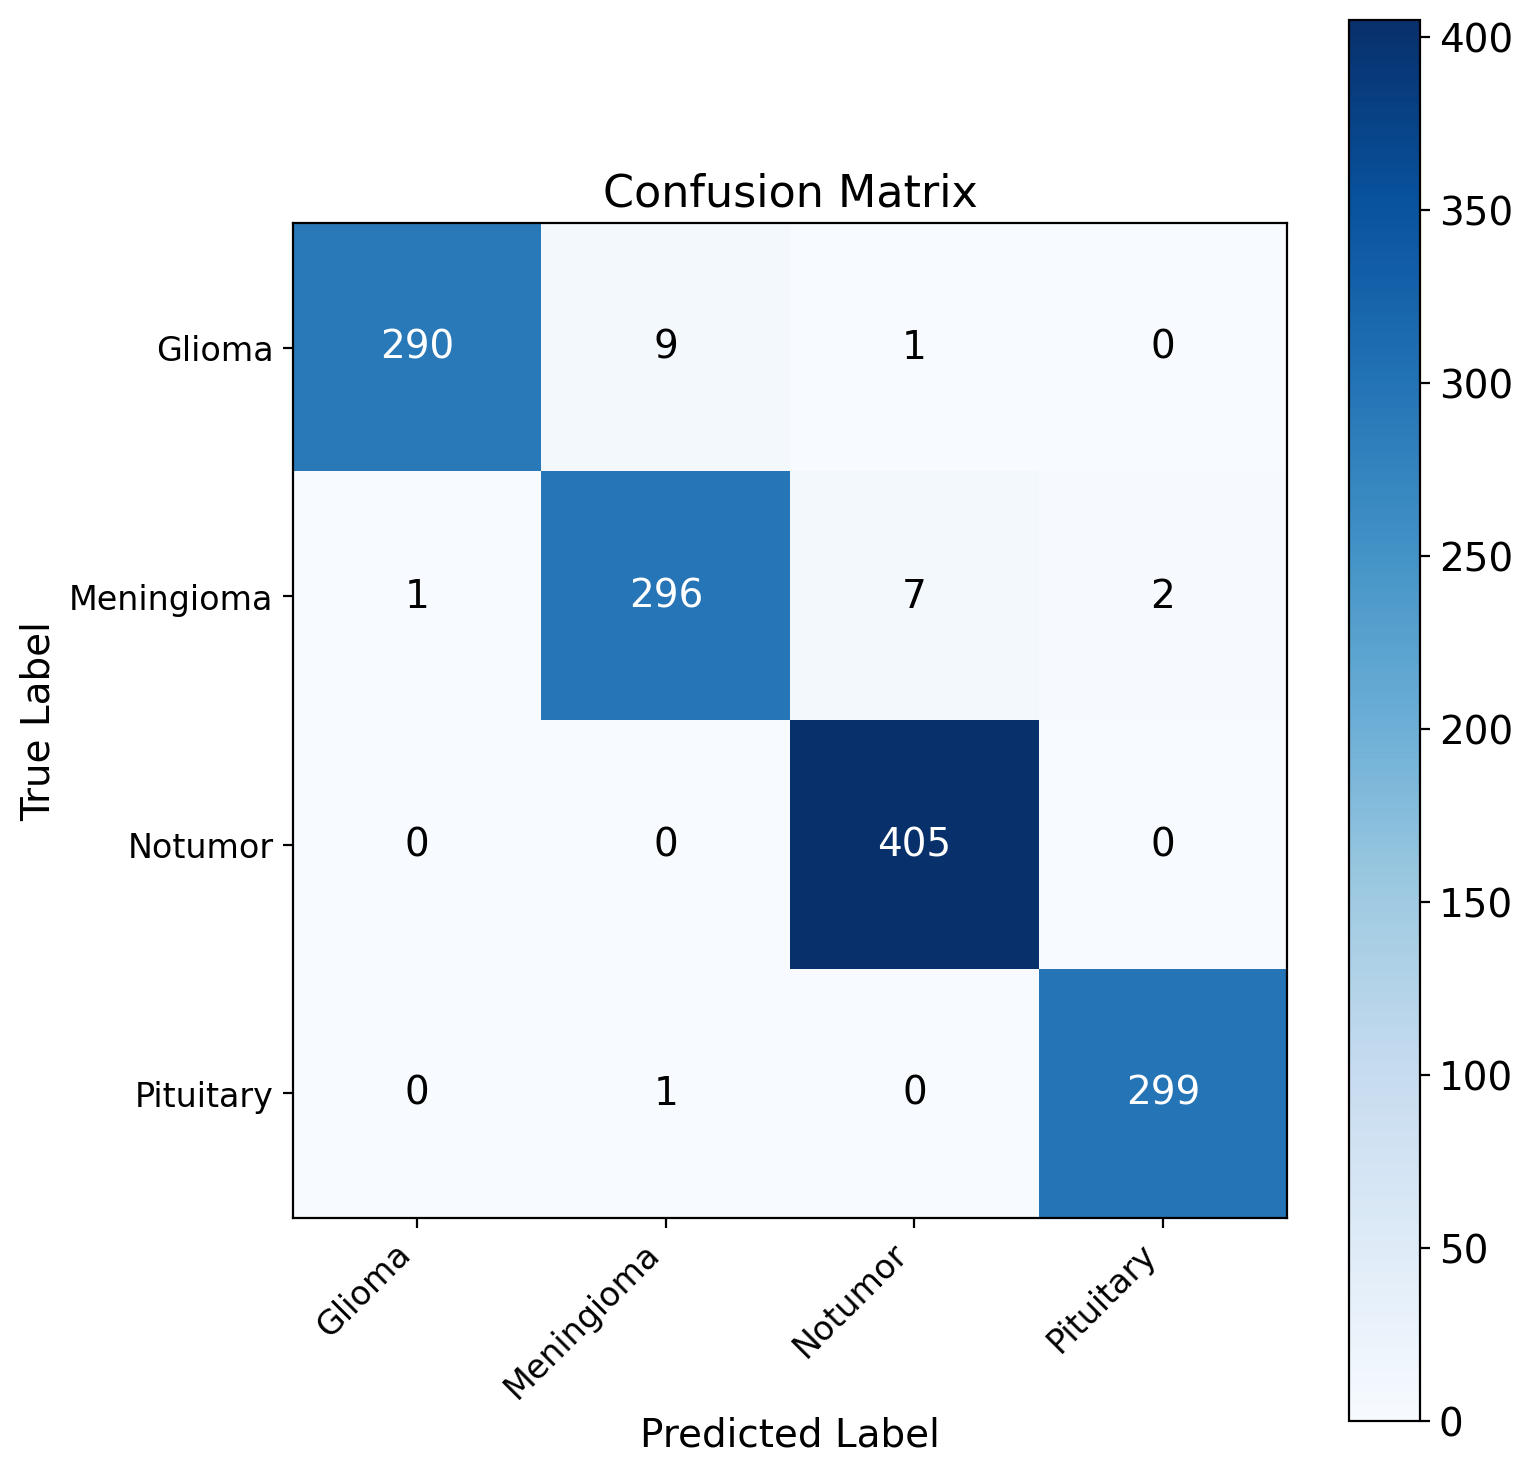

In [16]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def CM(CNN_model, test_generator, categories):
    """
    Computes and prints the confusion matrix for a CNN model's predictions on test data.

    Args:
        CNN_model: Trained CNN model.
        test_generator: Data generator for test data.
        categories: List of category/class names.

    Returns:
        Confusion matrix as a NumPy array.
    """
    # Step 1: Get the true labels and predictions
    true_labels = test_generator.classes
    predictions = CNN_model.predict(test_generator, steps=len(test_generator), verbose=1)
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Debugging: Verify true and predicted labels
    print(f"True labels (first 10): {true_labels[:10]}")
    print(f"Predicted labels (first 10): {predicted_labels[:10]}")
    
    # Step 2: Compute the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    print(f"Confusion Matrix Shape: {cm.shape}")
    print(f"Confusion Matrix:\n{cm}")
    
    return cm

# Get the confusion matrix
conf_matrix = CM(CNN_model=model, test_generator=test_generator, categories=class_indices_train_list)

# Ensure N_TYPES matches the number of categories
N_TYPES = len(class_indices_train_list)
assert conf_matrix.shape == (N_TYPES, N_TYPES), "Confusion matrix size mismatch!"

# Corrected plotting logic
plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix", fontsize=16)
plt.colorbar()

# Set tick labels
plt.xticks(np.arange(N_TYPES), [name.title() for name in class_indices_train_list], rotation=45, ha="right", fontsize=12)
plt.yticks(np.arange(N_TYPES), [name.title() for name in class_indices_train_list], fontsize=12)

# Annotate the matrix with values
threshold = conf_matrix.max() / 2  # Define threshold for text color
for i in range(N_TYPES):
    for j in range(N_TYPES):
        plt.text(j, i, f"{conf_matrix[i, j]}", 
                 ha="center", va="center", 
                 color="white" if conf_matrix[i, j] > threshold else "black")

# Axis labels
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)

# Adjust layout to prevent label overlap
plt.tight_layout()
plt.show()


In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_metrics(conf_matrix, categories):
    # Get the true and predicted labels from the confusion matrix
    true_labels = np.sum(conf_matrix, axis=1)  # Total true instances per class
    predicted_labels = np.sum(conf_matrix, axis=0)  # Total predicted instances per class

    # Calculate accuracy
    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)

    print(f"Accuracy: {accuracy * 100:.2f}%")

    # Iterate through the confusion matrix for per-class metrics
    for i, category in enumerate(categories):
        if np.sum(conf_matrix[:, i]) == 0:
            # If there are no true or predicted labels for this class, we cannot calculate precision/recall
            print(f"Metrics for class '{category}':")
            print(f"  Precision: Undefined")
            print(f"  Recall: Undefined")
            print(f"  F1-Score: Undefined")
        else:
            precision = conf_matrix[i, i] / np.sum(conf_matrix[:, i])  # True positives / (True positives + False positives)
            recall = conf_matrix[i, i] / np.sum(conf_matrix[i, :])  # True positives / (True positives + False negatives)
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

            print(f"Metrics for class '{category}':")
            print(f"  Precision: {precision:.2f}")
            print(f"  Recall: {recall:.2f}")
            print(f"  F1-Score: {f1:.2f}")
    
    return accuracy

# Get the confusion matrix
conf_matrix = CM(CNN_model=model, test_generator=test_generator, categories=class_indices_train_list)

# Now call the function with your confusion matrix
calculate_metrics(conf_matrix, categories=class_indices_train_list)


41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step
True labels (first 10): [0 0 0 0 0 0 0 0 0 0]
Predicted labels (first 10): [0 0 0 0 0 0 0 0 0 0]
Confusion Matrix Shape: (4, 4)
Confusion Matrix:
[[290   9   1   0]
 [  1 296   7   2]
 [  0   0 405   0]
 [  0   1   0 299]]
Accuracy: 98.40%
Metrics for class 'glioma':
  Precision: 1.00
  Recall: 0.97
  F1-Score: 0.98
Metrics for class 'meningioma':
  Precision: 0.97
  Recall: 0.97
  F1-Score: 0.97
Metrics for class 'notumor':
  Precision: 0.98
  Recall: 1.00
  F1-Score: 0.99
Metrics for class 'pituitary':
  Precision: 0.99
  Recall: 1.00
  F1-Score: 1.00


0.9839816933638444

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def plot_sample_predictions(model, test_generator, categories, num_samples=9, figsize=(10, 10)):
    """
    This function plots sample predictions from different classes.
    
    Parameters:
    - model: Trained Keras model for predictions
    - test_generator: The test data generator
    - categories: List of class names for the categories
    - num_samples: Number of sample images to display (should be equal to the number of classes)
    - figsize: The size of the figure for plotting
    """
    # Initialize a list to store images from each class
    class_images = {category: [] for category in categories}
    
    # Ensure we loop until we get at least one image per class
    while True:
        images, labels = next(test_generator)

        # Loop through the images and organize them by class
        for i in range(len(images)):
            true_class = categories[np.argmax(labels[i])]
            if true_class in class_images and len(class_images[true_class]) < 1:  # Take one sample from each class
                class_images[true_class].append((images[i], labels[i]))

        # If all classes have at least one image, break the loop
        if all(len(class_images[category]) > 0 for category in categories):
            break
    
    # Now, we have one image from each class (if available)
    selected_images = []
    selected_labels = []
    selected_titles = []
    
    # Check if we have at least one image per class, if not continue requesting batches
    for category in categories:
        if len(class_images[category]) > 0:
            image, label = class_images[category][0]
            selected_images.append(image)
            selected_labels.append(label)
            selected_titles.append(category)
        else:
            print(f"Warning: No image found for category '{category}'")
    
    # If not enough images are selected, show a warning
    if len(selected_images) < num_samples:
        print(f"Warning: Not enough images for all classes. Only {len(selected_images)} images selected.")
    
    # Plotting the selected images
    rows = int(np.sqrt(len(selected_images)))
    cols = int(np.ceil(len(selected_images) / rows))
    plt.figure(figsize=figsize)

    for i in range(len(selected_images)):
        # Get the image and true label
        image = selected_images[i]
        true_label = selected_labels[i]
        
        # Predict the class label
        prediction = model.predict(np.expand_dims(image, axis=0))
        predicted_class = np.argmax(prediction, axis=1)[0]
        
        # Get the category name for true and predicted class labels
        true_class_name = selected_titles[i]
        predicted_class_name = categories[predicted_class]
        
        # Plot the image and display the prediction
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"True: {true_class_name}\nPred: {predicted_class_name}")
    
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


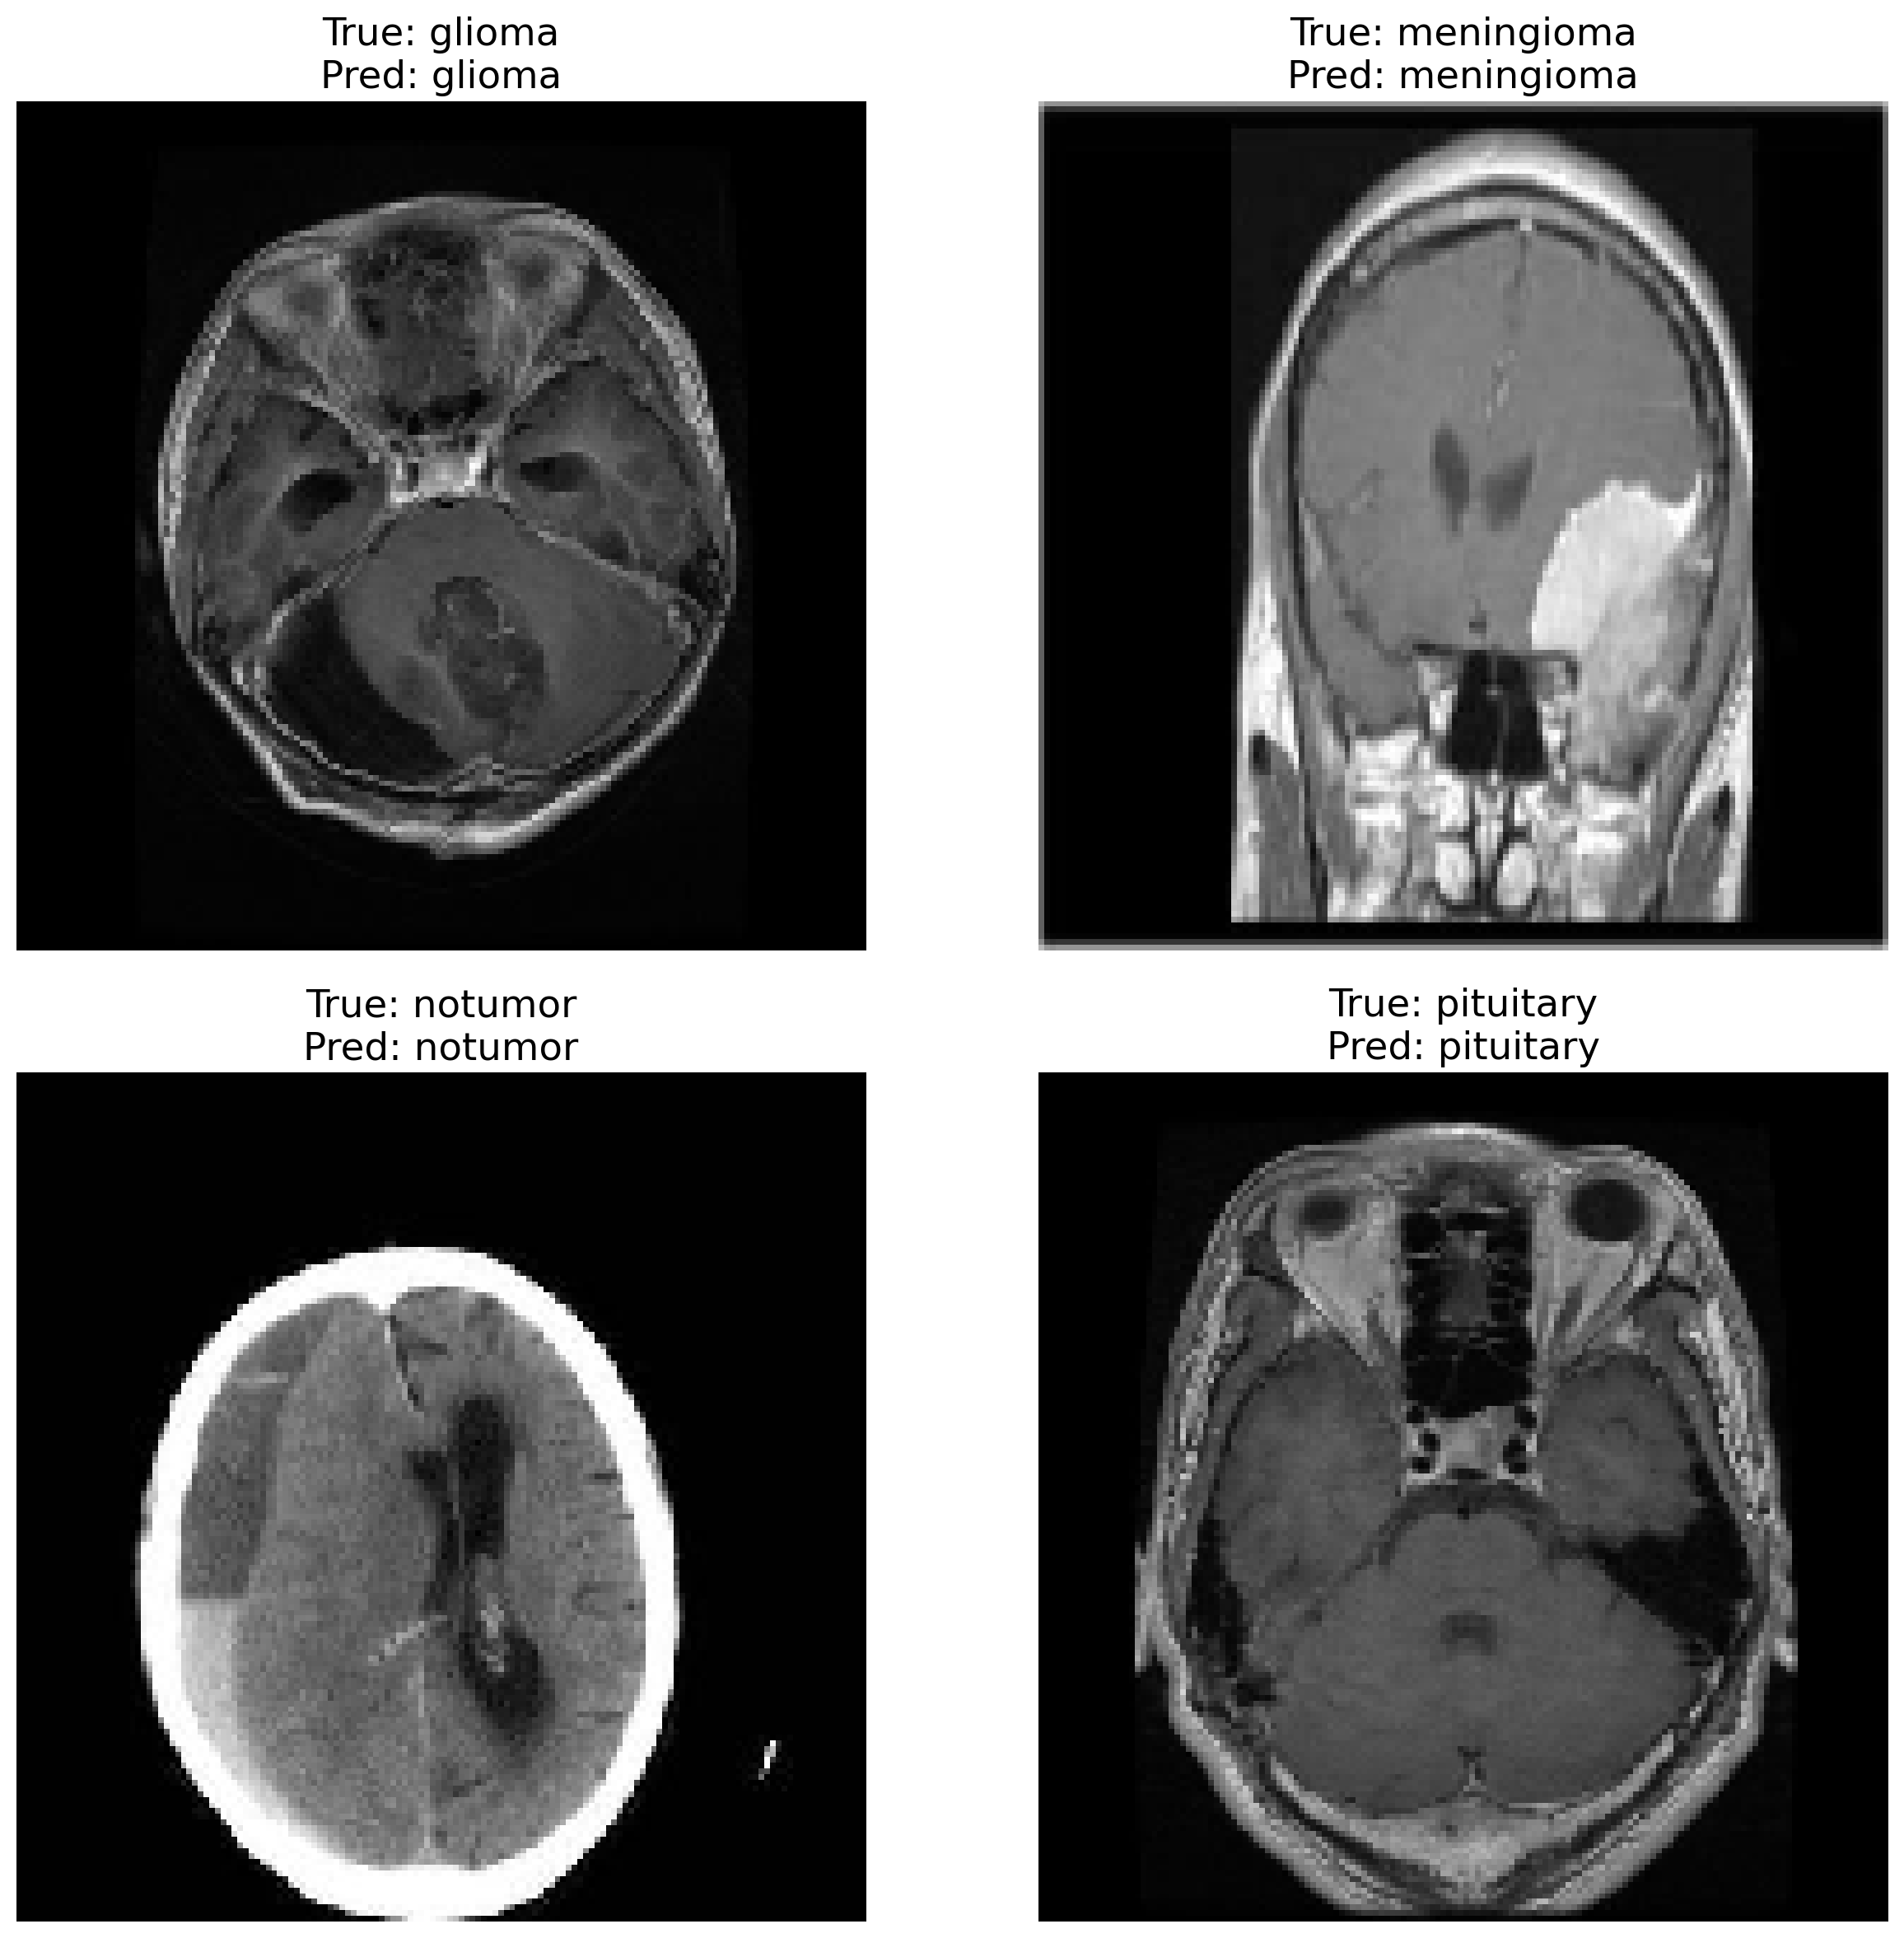

In [19]:
plot_sample_predictions(model=model, 
                        test_generator=test_generator, 
                        categories=class_indices_train_list,
                        num_samples=4,  # Number of samples (should be equal to number of classes)
                        figsize=(13, 12))


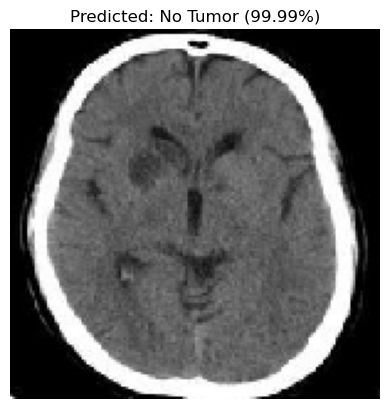

Predicted Class: No Tumor
Confidence: 99.99%


In [2]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

def test_single_image(model_path, image_path, categories, target_size=(150, 150)):
    """
    Loads a model, tests a single image, and displays the prediction.
    
    Parameters:
    - model_path: Path to the saved Keras model (e.g., .h5 file or directory).
    - image_path: Path to the image to be tested.
    - categories: List of class names corresponding to the output categories of the model.
    - target_size: Tuple specifying the image size expected by the model.
    
    Returns:
    - The predicted class and its probability.
    """
    # Load the trained model
    model = load_model(model_path)
    
    # Load and preprocess the image
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    
    # Get predictions
    predictions = model.predict(img_array, verbose=0)
    predicted_class_index = np.argmax(predictions)
    predicted_class = categories[predicted_class_index]
    confidence = predictions[0][predicted_class_index]
    
    # Display the image and prediction
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class} ({confidence * 100:.2f}%)")
    plt.axis('off')
    plt.show()
    
    return predicted_class, confidence

# Example usage
model_path = "best_model.keras"  # Replace with the path to your saved model
image_path = "Te-no_0010.jpg"  # Replace with the image path
categories = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']  # Update with your class names

predicted_class, confidence = test_single_image(model_path, image_path, categories)

print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence * 100:.2f}%")
